In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load and Pre-Process Data

In [2]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 16, "fontweight": "bold", "fontname": "Arial"}

font_dict_asterisk = {"fontsize": 20, "fontweight": "bold", "fontname": "Arial"}

In [3]:
# Whole-slide stats generated from wholeslide_stats.ipynb
ws_stats = pd.read_excel("../../../../Data/WS_stats.xlsx")

ws_stats = ws_stats.rename(columns={"sample": "sampleid", "annotation": "region", "density": "ws_density", "n_neighbour": "ws_n_neighbour"})

ws_stats = ws_stats[ws_stats["region"].isin(["tumour", "outer_IM"])].reset_index(drop=True)

In [4]:
ws_stats

,sampleid,region,ws_density,area_mm,hopkins,ws_n_neighbour,Subject ID,OS,Death,Sex,Race,Age
0,01_F,tumour,804.022884,198.490619,0.536679,14.494250,1,83.225806,1,F,B,64
1,01_F,outer_IM,962.356591,25.719157,0.538139,14.607300,1,83.225806,1,F,B,64
2,01_G,tumour,225.027071,29.463122,0.564916,23.102434,1,83.225806,1,F,B,64
3,01_G,outer_IM,283.130808,18.722795,0.625786,19.587908,1,83.225806,1,F,B,64
4,02_G,tumour,1049.946522,35.433233,0.529231,14.418908,2,15.833333,1,M,W,82
...,...,...,...,...,...,...,...,...,...,...,...,...
65,28_FSC,outer_IM,235.879758,22.337652,0.574625,25.250209,28,63.000000,1,F,W,80
66,29_L,tumour,116.881187,35.001356,0.557888,33.113278,29,47.806452,1,M,W,73
67,29_L,outer_IM,439.448216,46.328553,0.565720,19.221330,29,47.806452,1,M,W,73
68,30_D,tumour,122.400520,7.581667,0.582900,34.977897,30,1.266667,1,M,W,48


In [5]:
# Requisite files available in Figshare
# https://doi.org/10.6084/m9.figshare.28991807.v2

# Get Revised TMA locations and sampleids ===========================
tma_map = pd.read_excel("../../../../Data/CD8IHC_RevisedCoreMap.xlsx")

tma_map = tma_map[["x", "y", "PatientID", "BlockDesignation", "Revised Location", "Exclusion"]]

tma_map = tma_map[~tma_map["Exclusion"].isin(["LN", "X"])].reset_index(drop=True)

tma_map["(Row, Column)"] = [xy for xy in zip(tma_map["x"], tma_map["y"])]

tma_map = tma_map[tma_map["PatientID"] != 0].reset_index(drop=True)

tma_map["Revised Location"] = tma_map["Revised Location"].replace({"T": "tumour", "IM": "outer_IM"})

tma_map["sampleid"] = [f"{sample}_{block}" for sample, block in zip(tma_map["PatientID"], tma_map["BlockDesignation"])]

tma_map["sampleid"] = [f"0{sampleid}" if len(sampleid) == 3 else sampleid for sampleid in tma_map["sampleid"]]

tma_map = tma_map.drop(columns=["x", "y", "PatientID", "BlockDesignation", "Exclusion"])

tma_map_2 = pd.read_excel("../../../../Data/CD8IHC_RevisedCoreMap.xlsx")
tma_map_2 = tma_map_2[["x2", "y2", "Depth of Tumour- Core (mm)2"]]
tma_map_2 = tma_map_2.rename(columns={"Depth of Tumour- Core (mm)2": "tumour_depth"})
tma_map_2["(Row, Column)"] = [xy for xy in zip(tma_map_2["x2"], tma_map_2["y2"])]
tma_map_2 = tma_map_2.drop(columns=["x2", "y2"])

tma_map = tma_map.merge(tma_map_2, on="(Row, Column)", how="left")
# ====================================================================

# Get TMA densities ==================================================
tma_data = pd.read_csv("../../../../Data/TMA_CD8_SummaryData_MPIHC.csv")
tma_data = tma_data[["Spot Valid", "Case", "Location", "TMA Row", "TMA Column", "(Row, Column)", "CD8 Cells", "Tissue Area (μm²)"]]

tma_data = tma_data[tma_data["Spot Valid"] == 1].reset_index(drop=True)

tma_data["region"] = tma_data["Location"].replace({"T": "tumour", "IM": "outer_IM"})

tma_data["Area (mm)"] = tma_data["Tissue Area (μm²)"] / 1e6

tma_data["Density (mm)"] = tma_data["CD8 Cells"] / tma_data["Area (mm)"]

tma_data["(Row, Column)"] = [ast.literal_eval(xy) for xy in tma_data["(Row, Column)"]]

tma_data = tma_data.drop(columns=["Case", "TMA Row", "TMA Column", "Spot Valid", "Location", "Tissue Area (μm²)"])
# ====================================================================

tma_data = tma_data.merge(tma_map, on="(Row, Column)", how="left")

tma_data = tma_data[tma_data["sampleid"].isin(sampleids)].reset_index(drop=True)

# Get TMA Nearest Neighbour Distances =================================
nn_data = pd.read_excel("../../../../Data/TMA_Spatial/TMA_mean_NN_distances.xlsx")

nn_data["(Row, Column)"] = [f"({coords.split('_')[0]}, {coords.split('_')[1]})" for coords in nn_data["Coords"]]

nn_data["(Row, Column)"] = [ast.literal_eval(xy) for xy in nn_data["(Row, Column)"]]

tma_data = tma_data.merge(nn_data[["(Row, Column)", "Mean_NN_Distance"]], on="(Row, Column)", how="left")
# =====================================================================

In [6]:
# Excluded cores have no tumour_depth
tma_data

,"(Row, Column)",CD8 Cells,region,Area (mm),Density (mm),Revised Location,sampleid,tumour_depth,Mean_NN_Distance
0,"(1, 1)",216.0,tumour,0.781910,276.246516,tumour,04_I,NaN,2.894773
1,"(1, 2)",157.0,tumour,0.873067,179.825729,tumour,04_I,NaN,3.779852
2,"(1, 3)",232.0,tumour,1.141093,203.313929,tumour,04_I,NaN,3.685408
3,"(1, 4)",1146.0,outer_IM,1.019212,1124.398546,outer_IM,04_I,0.651,2.326020
4,"(2, 1)",117.0,tumour,0.943557,123.998909,tumour,06_H,NaN,7.229735
...,...,...,...,...,...,...,...,...,...
155,"(13, 11)",1019.0,outer_IM,1.195227,852.557626,tumour,01_F,NaN,2.532596
156,"(13, 12)",152.0,outer_IM,0.194482,781.564274,outer_IM,01_F,NaN,NaN
157,"(13, 13)",746.0,tumour,1.295595,575.797276,outer_IM,01_G,0.519,3.346073
158,"(13, 14)",176.0,tumour,0.539882,325.997125,outer_IM,01_G,NaN,NaN


In [7]:
tma_tum = tma_data[tma_data["Revised Location"] == "tumour"].reset_index(drop=True)
tma_im = tma_data[tma_data["Revised Location"] == "outer_IM"].reset_index(drop=True)

In [8]:
ws_tum = ws_stats[ws_stats["region"] == "tumour"].reset_index(drop=True)
ws_im = ws_stats[ws_stats["region"] == "outer_IM"].reset_index(drop=True)

# Post-QC1, Pre-QC2 Analyses

## IM vs CT Boxplots

In [8]:
ws_p = stats.wilcoxon(ws_im["ws_density"], ws_tum["ws_density"]).pvalue
tma_p = stats.mannwhitneyu(tma_im["Density (mm)"], tma_tum["Density (mm)"]).pvalue

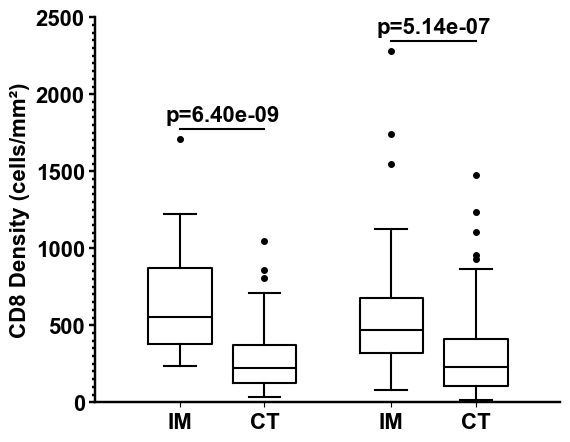

In [16]:
plt.subplots(figsize=(6, 5));

positions = [1, 2, 3.5, 4.5]

plt.boxplot([ws_im["ws_density"], ws_tum["ws_density"], tma_im["Density (mm)"], tma_tum["Density (mm)"]], tick_labels=["IM", "CT", "IM", "CT"], positions=positions, widths=0.75, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 4}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

x_max = 5.5
x_min = 0.0
plt.xlim(x_min, x_max)

y_min = 0.0
y_max = 2500
plt.ylim(y_min, y_max)

wsmin, wsmax, tmamin, tmamax = [(x - x_min) / (x_max - x_min) for x in positions]

plt.axhline(y=ws_stats["ws_density"].max() + 0.025 * y_max, color="black", linewidth=1.5, xmin=wsmin, xmax=wsmax)
plt.text(x=1.5, y=ws_stats["ws_density"].max() + 0.06 * y_max, s=f"p={ws_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.axhline(y=tma_data.sort_values("Density (mm)").reset_index(drop=True)["Density (mm)"].iloc[-1] + 0.025 * y_max, color="black", linewidth=1.5, xmin=tmamin, xmax=tmamax)
plt.text(x=4, y=tma_data.sort_values("Density (mm)").reset_index(drop=True)["Density (mm)"].iloc[-1] + 0.06 * y_max, s=f"p={tma_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(fontsize=16, fontname="Arial", fontweight="bold")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().set_yticks(np.arange(0, 2550, 50), minor=True)

plt.gca().tick_params(axis="y", which="major", length=4, width=1.75)
plt.gca().tick_params(axis="y", which="minor", length=2, width=1.75)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

plt.savefig("../../../../Data/Plots/Density/IM_vs_CT_CD8_density.png", dpi=300, bbox_inches="tight", transparent=True)

# Post-QC2 Analyses

## Preprocessing

In [9]:
# Brute force method to find depth of tumour core with 80% area
core_area = (0.6 ** 2) * np.pi
core_area_80 = core_area * 0.8

depth = 0.0
segment_area = 0.0

while segment_area < core_area_80:
    depth += 0.001
    segment_area = (0.6 ** 2) * (np.arccos((0.6 - depth) / 0.6)) - (0.6 - depth) * (2 * 0.6 * depth - depth ** 2) ** 0.5

print(f"Depth of tumour core with 80% area: {round(depth, 4)} mm")

Depth of tumour core with 80% area: 0.896 mm


In [10]:
tma_im = tma_im[(tma_im["tumour_depth"] >= 0.0) & (tma_im["tumour_depth"] <= depth)].dropna().reset_index(drop=True)

In [11]:
ws_im_paired = ws_im[ws_im["sampleid"].isin(tma_im["sampleid"])].reset_index(drop=True)[["sampleid", "ws_density", "ws_n_neighbour"]].rename(columns={"ws_density": "Density (mm)", "ws_n_neighbour": "Mean_NN_Distance"})
ws_im_paired["Modality"] = "WS"

In [12]:
tma_im_paired = tma_im[["sampleid", "Density (mm)", "Mean_NN_Distance"]]
tma_im_paired["Modality"] = "TMA"

C:\Users\Michael\AppData\Local\Temp\ipykernel_18780\3013791488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tma_im_paired["Modality"] = "TMA"


In [13]:
combined_im_paired = pd.concat([ws_im_paired, tma_im_paired]).sort_values(["sampleid", "Modality"]).reset_index(drop=True).groupby(["sampleid", "Modality"]).agg({"Density (mm)": "mean", "Mean_NN_Distance": "mean"}).reset_index()

In [14]:
ws_tum_paired = ws_tum[ws_tum["sampleid"].isin(tma_tum["sampleid"])].reset_index(drop=True)[["sampleid", "ws_density", "ws_n_neighbour"]].rename(columns={"ws_density": "Density (mm)", "ws_n_neighbour": "Mean_NN_Distance"})
ws_tum_paired["Modality"] = "WS"

In [15]:
tma_tum_paired = tma_tum[["sampleid", "Density (mm)"]]
tma_tum_paired["Modality"] = "TMA"

C:\Users\Michael\AppData\Local\Temp\ipykernel_18780\3482598575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tma_tum_paired["Modality"] = "TMA"


In [16]:
combined_tum_paired = pd.concat([ws_tum_paired, tma_tum_paired]).sort_values(["sampleid", "Modality"]).reset_index(drop=True).groupby(["sampleid", "Modality"]).agg({"Density (mm)": "mean", "Mean_NN_Distance": "mean"}).reset_index()

## Paired TMA vs WS CD8 Density Boxplots

In [17]:
paired_ws = combined_im_paired[combined_im_paired["Modality"] == "WS"]

paired_tma = combined_im_paired[combined_im_paired["Modality"] == "TMA"].groupby("sampleid").agg({"Density (mm)": "mean"}).reset_index()

In [18]:
stats.wilcoxon(paired_ws["Density (mm)"], paired_tma["Density (mm)"])

WilcoxonResult(statistic=82.0, pvalue=0.09175300598144531)

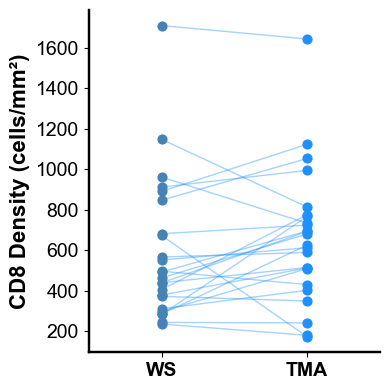

In [36]:
import matplotlib.pyplot as plt

x_map = {"WS": 2, "TMA": 3}

fig, ax = plt.subplots(figsize=(4, 4))

plt.xlim(1.5, 3.5)

for sampleid, g in combined_im_paired.groupby("sampleid"):
    gA = g[g["Modality"] == "WS"]
    gB = g[g["Modality"] == "TMA"]

    # plot points
    ax.scatter(gA["Modality"].map(x_map), gA["Density (mm)"], s=40, zorder=2, color="steelblue")
    ax.scatter(gB["Modality"].map(x_map), gB["Density (mm)"], s=40, zorder=2, color="dodgerblue")
    # connect A -> each B (no B->B lines)
    if not gA.empty and not gB.empty:
        yA = float(gA["Density (mm)"].iloc[0])  # assumes one A per sampleid
        for yB in gB["Density (mm)"].to_numpy():
            ax.plot([x_map["WS"], x_map["TMA"]], [yA, yB], alpha=0.4, linewidth=1, zorder=1, color="dodgerblue")


plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

ax.set_xticks([2, 3])
ax.set_xticklabels(["WS", "TMA"])
ax.set_ylabel("CD8 density")

plt.yticks(fontsize=14, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial", fontweight="bold")

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/Density/WS_vs_TMA_paired_CD8_density.png", dpi=600, bbox_inches="tight", transparent=True)

In [29]:
paired_ws = combined_tum_paired[combined_tum_paired["Modality"] == "WS"]

paired_tma = combined_tum_paired[combined_tum_paired["Modality"] == "TMA"].groupby("sampleid").agg({"Density (mm)": "mean"}).reset_index()

In [30]:
stats.wilcoxon(paired_ws["Density (mm)"], paired_tma["Density (mm)"])

WilcoxonResult(statistic=231.0, pvalue=0.7498410120606422)

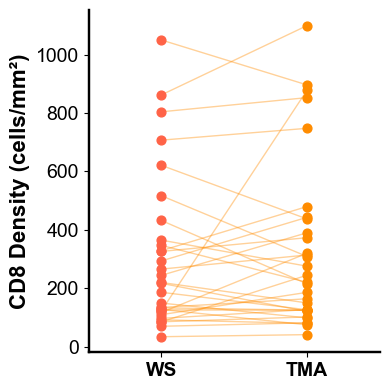

In [37]:
x_map = {"WS": 2, "TMA": 3}

fig, ax = plt.subplots(figsize=(4, 4))

plt.xlim(1.5, 3.5)

for sampleid, g in combined_tum_paired.groupby("sampleid"):
    gA = g[g["Modality"] == "WS"]
    gB = g[g["Modality"] == "TMA"]

    # plot points
    ax.scatter(gA["Modality"].map(x_map), gA["Density (mm)"], s=40, zorder=2, color="tomato")
    ax.scatter(gB["Modality"].map(x_map), gB["Density (mm)"], s=40, zorder=2, color="darkorange")
    # connect A -> each B (no B->B lines)
    if not gA.empty and not gB.empty:
        yA = float(gA["Density (mm)"].iloc[0])  # assumes one A per sampleid
        for yB in gB["Density (mm)"].to_numpy():
            ax.plot([x_map["WS"], x_map["TMA"]], [yA, yB], alpha=0.4, linewidth=1, zorder=1, color="darkorange")


plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

ax.set_xticks([2, 3])
ax.set_xticklabels(["WS", "TMA"])
ax.set_ylabel("CD8 density")

plt.yticks(fontsize=14, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial", fontweight="bold")

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/Density/WS_vs_TMA_tum_paired_CD8_density.png", dpi=600, bbox_inches="tight", transparent=True)

## Paired CD8 Densities by Core Number

In [19]:
im_cores = pd.concat([ws_im_paired, tma_im_paired]).sort_values(["sampleid", "Modality"]).reset_index(drop=True).groupby(["sampleid", "Modality"]).agg({"Density (mm)": "count"}).reset_index().rename(columns={"Density (mm)": "Cores"})

multiple_im_cores = im_cores[im_cores["Cores"] > 1].reset_index(drop=True)["sampleid"]

multiple_im_cores = combined_im_paired[combined_im_paired["sampleid"].isin(multiple_im_cores)].reset_index(drop=True)

single_im_core = im_cores[(im_cores["Cores"] == 1) & (im_cores["Modality"] == "TMA")].reset_index(drop=True)["sampleid"]

single_im_core = combined_im_paired[combined_im_paired["sampleid"].isin(single_im_core)].reset_index(drop=True)

In [20]:
stats.wilcoxon(multiple_im_cores[multiple_im_cores["Modality"] == "WS"]["Density (mm)"], multiple_im_cores[multiple_im_cores["Modality"] == "TMA"]["Density (mm)"])

WilcoxonResult(statistic=34.0, pvalue=0.267578125)

In [21]:
stats.wilcoxon(single_im_core[single_im_core["Modality"] == "WS"]["Density (mm)"], single_im_core[single_im_core["Modality"] == "TMA"]["Density (mm)"])

WilcoxonResult(statistic=14.0, pvalue=0.359375)

In [51]:
tum_cores = pd.concat([ws_tum_paired, tma_tum_paired]).sort_values(["sampleid", "Modality"]).reset_index(drop=True).groupby(["sampleid", "Modality"]).agg({"Density (mm)": "count"}).reset_index().rename(columns={"Density (mm)": "Cores"})

multiple_tum_cores = tum_cores[tum_cores["Cores"] > 1].reset_index(drop=True)["sampleid"]

multiple_tum_cores = combined_tum_paired[combined_tum_paired["sampleid"].isin(multiple_tum_cores)].reset_index(drop=True)

single_tum_core = tum_cores[(tum_cores["Cores"] == 1) & (tum_cores["Modality"] == "TMA")].reset_index(drop=True)["sampleid"]

single_tum_core = combined_tum_paired[combined_tum_paired["sampleid"].isin(single_tum_core)].reset_index(drop=True)

In [52]:
stats.wilcoxon(multiple_tum_cores[multiple_tum_cores["Modality"] == "WS"]["Density (mm)"], multiple_tum_cores[multiple_tum_cores["Modality"] == "TMA"]["Density (mm)"])

WilcoxonResult(statistic=146.0, pvalue=0.6720751523971558)

In [53]:
stats.wilcoxon(single_tum_core[single_tum_core["Modality"] == "WS"]["Density (mm)"], single_tum_core[single_tum_core["Modality"] == "TMA"]["Density (mm)"])

WilcoxonResult(statistic=7.0, pvalue=0.5625)

## WS vs TMA CD8 Densities in Excluded vs Included Cores

In [8]:
# Get excluded cores
excluded_tma_im = tma_im[(tma_im["tumour_depth"] < 0.0) | (tma_im["tumour_depth"] > depth) | (tma_im["tumour_depth"].isnull())].reset_index(drop=True)

ex_tma_im_high = excluded_tma_im[excluded_tma_im["tumour_depth"] > depth].reset_index(drop=True)

ex_tma_im_null = excluded_tma_im[excluded_tma_im["tumour_depth"].isnull()].reset_index(drop=True)

In [13]:
im_excluded_p = stats.mannwhitneyu(ws_im["ws_density"], excluded_tma_im["Density (mm)"]).pvalue

In [14]:
im_excluded_p

0.007158540398750338

In [35]:
im_ex_high_p = stats.mannwhitneyu(ws_im["ws_density"], ex_tma_im_high["Density (mm)"]).pvalue

im_ex_null_p = stats.mannwhitneyu(ws_im["ws_density"], ex_tma_im_null["Density (mm)"]).pvalue

In [36]:
im_ex_high_p

0.03325841980049819

In [37]:
im_ex_null_p

0.01867410788062806

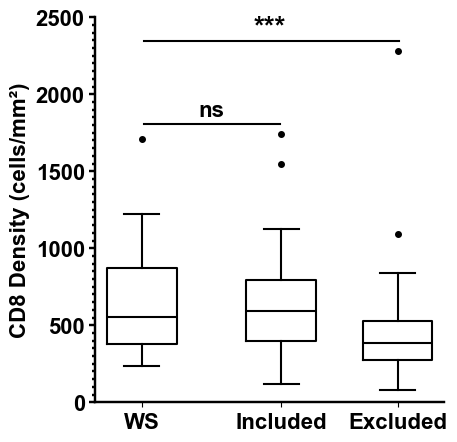

In [15]:
plt.subplots(figsize=(6/4*3, 5));

positions = [1, 2.5, 3.75]

plt.boxplot([ws_im["ws_density"], tma_im["Density (mm)"], excluded_tma_im["Density (mm)"]], tick_labels=["WS", "Included", "Excluded"], positions=positions, widths=0.75, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 4}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

x_max = 6/4*3
x_min = 0.0
# plt.xlim(x_min, x_max)

y_min = 0.0
y_max = 2500
plt.ylim(y_min, y_max)

wsmin, tmamin, tmamax = [(x - x_min) / (x_max - x_min) for x in positions]

plt.axhline(y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=0.14, xmax=0.53)
plt.text(x=1.75, y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.06 * y_max, s="ns", ha="center", va="center", fontdict=font_dict)

plt.axhline(y=max(ws_im["ws_density"].max(), excluded_tma_im["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=0.14, xmax=0.87)
plt.text(x=(1 + 3.75)/2, y=max(ws_im["ws_density"].max(), excluded_tma_im["Density (mm)"].max()) + 0.06 * y_max, s="***", ha="center", va="center", fontdict=font_dict_asterisk)

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(np.arange(0, 3000, 500), fontsize=16, fontname="Arial", fontweight="bold")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().set_yticks(np.arange(0, 2550, 50), minor=True)

plt.gca().tick_params(axis="y", which="major", length=4, width=1.75)
plt.gca().tick_params(axis="y", which="minor", length=2, width=1.75)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

# plt.savefig("../../../../Data/Plots/Density/WS_vs_TMA_exclusions_CD8_density.png", dpi=600, bbox_inches="tight", transparent=True)

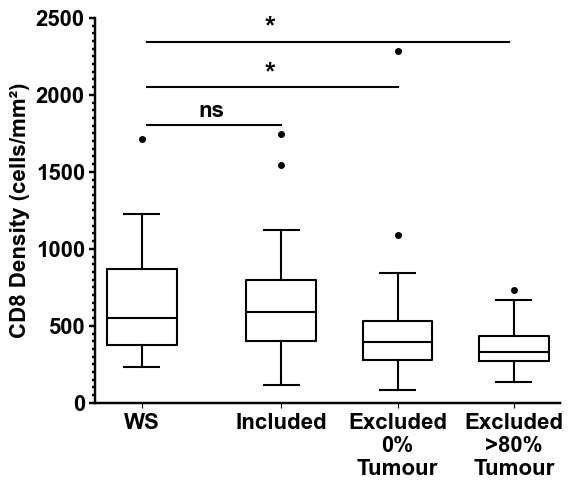

In [38]:
plt.subplots(figsize=(6/4*4, 5));

positions = [1, 2.5, 3.75, 5.0]

plt.boxplot([ws_im["ws_density"], tma_im["Density (mm)"], ex_tma_im_null["Density (mm)"], ex_tma_im_high["Density (mm)"]], labels=["WS", "Included", "Excluded\n0%\nTumour", "Excluded\n>80%\nTumour"], positions=positions, widths=0.75, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 4}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

x_max = 6/4*3
x_min = 0.0
# plt.xlim(x_min, x_max)

y_min = 0.0
y_max = 2500
plt.ylim(y_min, y_max)

wsmin, tmamin, tmamid, tmamax = [(x - x_min) / (x_max - x_min) for x in positions]

plt.axhline(y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=0.11, xmax=0.4)
plt.text(x=1.75, y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.06 * y_max, s="ns", ha="center", va="center", fontdict=font_dict)

plt.axhline(y=max(ws_im["ws_density"].max(), ex_tma_im_null["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=0.11, xmax=0.89)
plt.text(x=(1 + 3.75)/2, y=max(ws_im["ws_density"].max(), ex_tma_im_null["Density (mm)"].max()) + 0.06 * y_max, s="*", ha="center", va="center", fontdict=font_dict_asterisk)

plt.axhline(y=max(ws_im["ws_density"].max() + 275, ex_tma_im_high["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=0.11, xmax=0.65)
plt.text(x=(1 + 3.75)/2, y=max(ws_im["ws_density"].max() + 275, ex_tma_im_high["Density (mm)"].max()) + 0.06 * y_max, s="*", ha="center", va="center", fontdict=font_dict_asterisk)

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(np.arange(0, 3000, 500), fontsize=16, fontname="Arial", fontweight="bold")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().set_yticks(np.arange(0, 2550, 50), minor=True)

plt.gca().tick_params(axis="y", which="major", length=4, width=1.75)
plt.gca().tick_params(axis="y", which="minor", length=2, width=1.75)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

plt.savefig("../../../../Data/Plots/Density/WS_vs_TMA_exclusions_2_CD8_density.png", dpi=600, bbox_inches="tight", transparent=True)

## WS vs TMA CD8 Density at IM and CT

In [25]:
im_p = stats.mannwhitneyu(ws_im["ws_density"], tma_im["Density (mm)"]).pvalue
ct_p = stats.mannwhitneyu(ws_tum["ws_density"], tma_tum["Density (mm)"]).pvalue

In [26]:
im_p, ct_p

(0.8525639730669545, 0.9519225528580172)

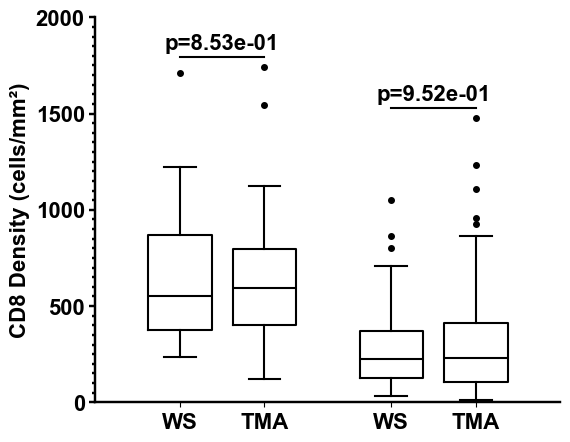

In [13]:
plt.subplots(figsize=(6, 5));

positions = [1, 2, 3.5, 4.5]

plt.boxplot([ws_im["ws_density"], tma_im["Density (mm)"], ws_tum["ws_density"], tma_tum["Density (mm)"]], tick_labels=["WS", "TMA", "WS", "TMA"], positions=positions, widths=0.75, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 4}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

x_max = 5.5
x_min = 0.0
plt.xlim(x_min, x_max)

y_min = 0.0
y_max = 2000
plt.ylim(y_min, y_max)

wsmin, wsmax, tmamin, tmamax = [(x - x_min) / (x_max - x_min) for x in positions]

plt.axhline(y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=wsmin, xmax=wsmax)
plt.text(x=1.5, y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.06 * y_max, s=f"p={im_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.axhline(y=max(ws_tum["ws_density"].max(), tma_tum["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=tmamin, xmax=tmamax)
plt.text(x=4, y=max(ws_tum["ws_density"].max(), tma_tum["Density (mm)"].max()) + 0.06 * y_max, s=f"p={ct_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(np.arange(0, 2500, 500), fontsize=16, fontname="Arial", fontweight="bold")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().set_yticks(np.arange(0, 2050, 50), minor=True)

plt.gca().tick_params(axis="y", which="major", length=4, width=1.75)
plt.gca().tick_params(axis="y", which="minor", length=2, width=1.75)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

plt.savefig("../../../../Data/Plots/Density/WS_vs_TMA_CD8_density.png", dpi=300, bbox_inches="tight", transparent=True)

## Paired CD8 NN Distances by Core Number

In [17]:
im_cores = pd.concat([ws_im_paired, tma_im_paired]).sort_values(["sampleid", "Modality"]).reset_index(drop=True).groupby(["sampleid", "Modality"]).agg({"Mean_NN_Distance": "count"}).reset_index().rename(columns={"Mean_NN_Distance": "Cores"})

multiple_im_cores = im_cores[im_cores["Cores"] > 1].reset_index(drop=True)["sampleid"]
multiple_im_cores = combined_im_paired[combined_im_paired["sampleid"].isin(multiple_im_cores)].reset_index(drop=True)

single_im_core = im_cores[(im_cores["Cores"] == 1) & (im_cores["Modality"] == "TMA")].reset_index(drop=True)["sampleid"]
single_im_core = combined_im_paired[combined_im_paired["sampleid"].isin(single_im_core)].reset_index(drop=True)

In [18]:
stats.wilcoxon(multiple_im_cores[multiple_im_cores["Modality"] == "WS"]["Mean_NN_Distance"], multiple_im_cores[multiple_im_cores["Modality"] == "TMA"]["Mean_NN_Distance"])

WilcoxonResult(statistic=0.0, pvalue=0.0001220703125)

In [19]:
stats.wilcoxon(single_im_core[single_im_core["Modality"] == "WS"]["Mean_NN_Distance"], single_im_core[single_im_core["Modality"] == "TMA"]["Mean_NN_Distance"])

WilcoxonResult(statistic=0.0, pvalue=0.00390625)

In [41]:
multi_error = (abs(multiple_im_cores[multiple_im_cores["Modality"] == "WS"]["Mean_NN_Distance"].values - multiple_im_cores[multiple_im_cores["Modality"] == "TMA"]["Mean_NN_Distance"].values) / multiple_im_cores[multiple_im_cores["Modality"] == "WS"]["Mean_NN_Distance"].values)

In [42]:
single_error = (abs(single_im_core[single_im_core["Modality"] == "WS"]["Mean_NN_Distance"].values - single_im_core[single_im_core["Modality"] == "TMA"]["Mean_NN_Distance"].values) / single_im_core[single_im_core["Modality"] == "WS"]["Mean_NN_Distance"].values)

In [43]:
stats.mannwhitneyu(multi_error, single_error)

MannwhitneyuResult(statistic=50.0, pvalue=0.43103254006573466)

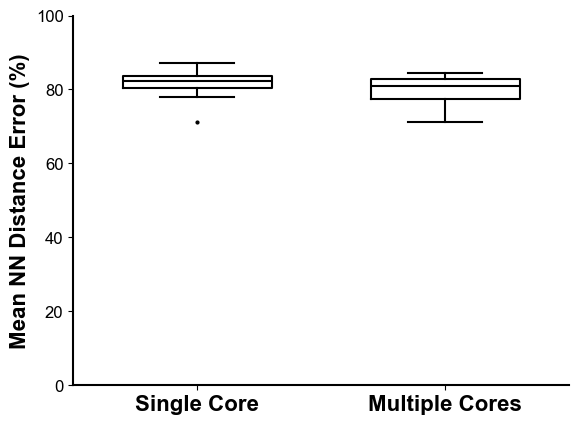

In [58]:
plt.boxplot([single_error * 100, multi_error * 100], tick_labels=["Single Core", "Multiple Cores"], widths=0.6, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 2}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

plt.ylim(0, 100)

plt.ylabel("Mean NN Distance Error (%)", fontdict=font_dict)

plt.yticks(fontsize=12, fontname="Arial")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_linewidth(1.5)
plt.gca().spines["bottom"].set_linewidth(1.5)

## TMA ws WS Mean Nearest-Neighbour Error

In [31]:
tma_im

,"(Row, Column)",CD8 Cells,region,Area (mm),Density (mm),Revised Location,sampleid,tumour_depth,Mean_NN_Distance
0,"(1, 4)",1146.0,outer_IM,1.019212,1124.398546,outer_IM,04_I,0.6510,2.326020
1,"(2, 2)",1281.0,outer_IM,1.172391,1092.639239,outer_IM,06_H,0.4630,2.472165
2,"(2, 3)",157.0,outer_IM,0.980300,160.154983,outer_IM,06_H,0.8670,5.730723
3,"(3, 4)",641.0,outer_IM,1.235733,518.720415,outer_IM,10_B,0.2620,3.056849
4,"(3, 5)",800.0,outer_IM,1.211644,660.259740,outer_IM,10_B,0.6760,2.985277
5,"(3, 10)",306.0,outer_IM,0.787024,388.806255,outer_IM,11_F,0.3170,5.238911
6,"(3, 11)",343.0,outer_IM,1.103562,310.811752,outer_IM,11_F,0.7480,4.852754
7,"(4, 4)",420.0,tumour,1.123290,373.901497,outer_IM,13_G,0.0350,3.923667
8,"(4, 8)",597.0,outer_IM,1.223815,487.818879,outer_IM,13_G,0.8840,3.463005
9,"(4, 12)",917.0,outer_IM,1.180767,776.613681,outer_IM,14_I,0.0834,2.906722
